### **Condicional GAN with MNIST Dataset**

**Importing Libraries**

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torchvision import transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
import numpy as np

In [ ]:
epochs=50
z_dim=64
n_classes=10
batch_size=128
lr=0.0002
betas=(0.5, 0.999)
device="cuda"
display_step=500

In [ ]:
class Generator(nn.Module):

  def __init__(self, input_dim=z_dim+n_classes, im_channels=1, hidden_dim=64):
    super().__init__()

    self.generator = nn.Sequential(
        self.generator_block(input_dim, hidden_dim*4),
        self.generator_block(hidden_dim*4, hidden_dim*2, kernel_size=4, stride=1),
        self.generator_block(hidden_dim*2, hidden_dim),
        self.generator_block(hidden_dim, im_channels, kernel_size=4, final_layer=True)
    )

  def generator_block(self, input_chanels, output_chanels, kernel_size=3, stride=2, final_layer=False):
    if not final_layer:
      return nn.Sequential(
          nn.ConvTranspose2d(input_chanels, output_chanels, kernel_size, stride),
          nn.BatchNorm2d(output_chanels),
          nn.ReLU()
      )
    else:
      return nn.Sequential(
          nn.ConvTranspose2d(input_chanels, output_chanels, kernel_size, stride),
          nn.Tanh()
      )

  def forward(self, noise):
    return self.generator(noise)

In [ ]:
generator=Generator().to(device)
summary(generator, (z_dim+n_classes, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         170,752
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 770,881
Trainable params: 770,881
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:
class Discriminator(nn.Module):

  def __init__(self, im_channels=1+n_classes, hidden_dim=64):
    super().__init__()

    self.discriminator = nn.Sequential(
        self.discriminator_block(im_channels, hidden_dim),
        self.discriminator_block(hidden_dim, hidden_dim*2),
        self.discriminator_block(hidden_dim*2, 1, final_layer=True)
    )

  def discriminator_block(self, input_chanels, output_chanels, kernel_size=4, stride=2, final_layer=False):
    if not final_layer:
      return nn.Sequential(
          nn.Conv2d(input_chanels, output_chanels, kernel_size, stride),
          nn.BatchNorm2d(output_chanels),
          nn.LeakyReLU(0.2)
      )
    else:
      return nn.Sequential(
          nn.Conv2d(input_chanels, output_chanels, kernel_size, stride)
      )

  def forward(self, image):
    return self.discriminator(image)

In [ ]:
discriminator=Discriminator().to(device)

summary(discriminator, (1+n_classes, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 13, 13]          11,328
       BatchNorm2d-2           [-1, 64, 13, 13]             128
         LeakyReLU-3           [-1, 64, 13, 13]               0
            Conv2d-4            [-1, 128, 5, 5]         131,200
       BatchNorm2d-5            [-1, 128, 5, 5]             256
         LeakyReLU-6            [-1, 128, 5, 5]               0
            Conv2d-7              [-1, 1, 1, 1]           2,049
Total params: 144,961
Trainable params: 144,961
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.32
Params size (MB): 0.55
Estimated Total Size (MB): 0.91
----------------------------------------------------------------


In [ ]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

train_dataset=DataLoader(
    MNIST(".", transform=transform, download=True),
    batch_size=batch_size,
    shuffle=True)

In [ ]:
for im_examples, lb_examples in train_dataset:
  break

im_examples.shape, lb_examples.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

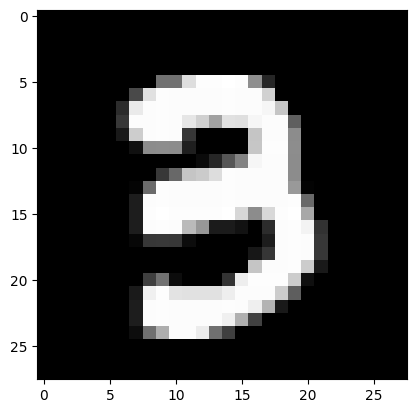

In [ ]:
plt.imshow(im_examples[0].permute(1, 2, 0), cmap="gray");

In [ ]:
gen_optimizer=torch.optim.Adam(generator.parameters(), lr=lr, betas=betas)
disc_optimizer=torch.optim.Adam(discriminator.parameters(), lr=lr, betas=betas)
criterion=nn.BCEWithLogitsLoss()

In [ ]:
def weights_init(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02)
  if isinstance(m, nn.BatchNorm2d):
     torch.nn.init.normal_(m.weight, 0.0, 0.02)
     torch.nn.init.constant_(m.bias, 0)

generator=generator.apply(weights_init)
discriminator=discriminator.apply(weights_init)

In [ ]:
def show_images(real_images, fake_images, num_images=25, nrow=5, cmap="gray"):

  real_images=real_images.cpu()
  fake_images=fake_images.cpu()

  # Denormalization
  real_images=(real_images+1)/2 #[0., 1.]
  fake_images=(fake_images+1)/2 #[0., 1.]

  real_images=make_grid(real_images[:num_images], nrow=nrow).permute(1, 2, 0)
  fake_images=make_grid(fake_images[:num_images], nrow=nrow).permute(1, 2, 0)

  fig, ax = plt.subplots(1, 2, figsize=(nrow*2, nrow*2))
  ax[0].imshow(fake_images, cmap=cmap)
  ax[0].axis("off")
  ax[0].set_title("Generated Images")

  ax[1].imshow(real_images, cmap=cmap)
  ax[1].axis("off")
  ax[1].set_title("Real Images")

  plt.show()

def show_losses(generator_losses, discriminator_losses, step):
  plt.figure(figsize=(10, 5))
  plt.plot(np.arange(step-len(generator_losses)+1, step+1), generator_losses, label="Generator Loss")
  plt.plot(np.arange(step-len(discriminator_losses)+1, step+1), discriminator_losses, label="Discriminator Loss")
  plt.title("Losses Through Steps")
  plt.xlabel("Step")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

def concat_vectors(x, y):
  concat = torch.concat([x.to(dtype=torch.float32), y.to(dtype=torch.float32)], dim=1)
  return concat

In [ ]:
def train_gan(epochs=50, display_wait=False):
  step=1
  generator_losses=[]
  discriminator_losses=[]

  for epoch in range(epochs):
    with tqdm(train_dataset) as pbar:
      pbar.set_description(f"[Epoch: {epoch+1}]/{epochs}")
      for real_images, labels in pbar:
        cur_batch_size=len(real_images)

        real_images=real_images.to(device)
        labels_ohe=nn.functional.one_hot(labels.to(device), n_classes)

        images_ohe=labels_ohe[:, :, None, None]
        images_ohe=images_ohe.repeat(1, 1, 28, 28) #shape=(cur_batch_size, n_classes, 28, 28)

        # Update discriminator
        disc_optimizer.zero_grad()
        noise=torch.randn(cur_batch_size, z_dim, device=device)
        noise_labels=concat_vectors(noise, labels_ohe)[:, :, None, None]
        fake_images=generator(noise_labels)
        fake_out=discriminator(concat_vectors(fake_images.detach(), images_ohe))
        fake_loss=criterion(fake_out, torch.zeros_like(fake_out))

        real_out=discriminator(concat_vectors(real_images, images_ohe))
        real_loss=criterion(real_out, torch.ones_like(real_out))

        disc_loss=(fake_loss+real_loss)/2
        disc_loss.backward(retain_graph=True)
        disc_optimizer.step()

        discriminator_losses.append(disc_loss.item())

        # Update Generator
        gen_optimizer.zero_grad()
        fake_out=discriminator(concat_vectors(fake_images, images_ohe))
        gen_loss=criterion(fake_out, torch.ones_like(fake_out))

        gen_loss.backward(retain_graph=True)
        gen_optimizer.step()

        generator_losses.append(gen_loss.item())

        #Visualization
        pbar.set_postfix({"Step": step, "gen_loss": gen_loss.item(), "disc_loss": disc_loss.item()})

        if step%display_step==0:
          display.clear_output(wait=display_wait)

          mean_generator_loss=np.mean(generator_losses[-display_step:])
          mean_discriminator_loss=np.mean(discriminator_losses[-display_step:])
          print(f"Epoch {epoch+1}, Step {step}: MeanGeneratorLoss: {mean_generator_loss}, MeanDiscriminatorLoss: {mean_discriminator_loss}")

          show_images(real_images, fake_images.detach())
          show_losses(generator_losses[-display_step:], discriminator_losses[-display_step:], step)

        step+=1

Epoch 50, Step 23000: MeanGeneratorLoss: 0.8008468441367149, MeanDiscriminatorLoss: 0.6652500993013382


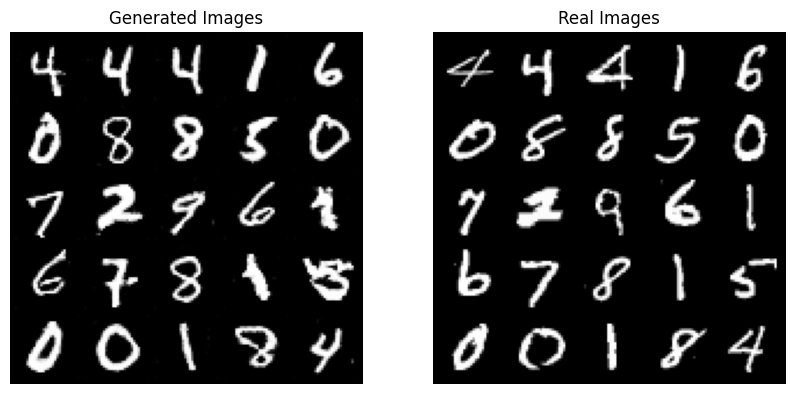

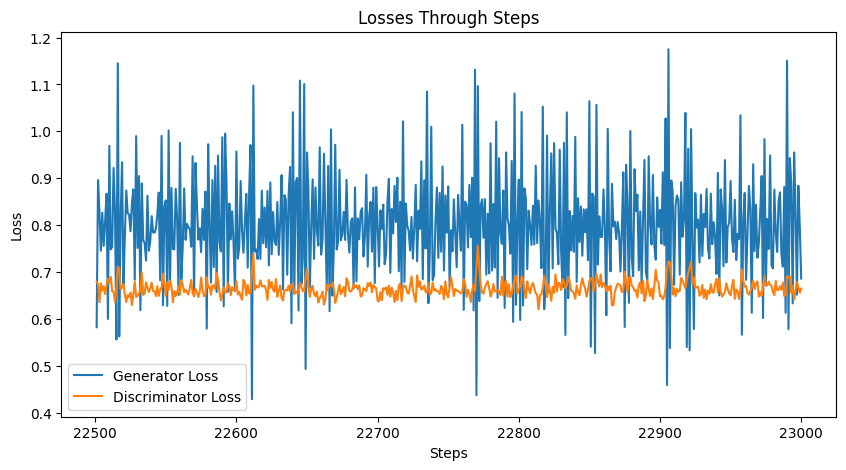

[Epoch: 50]: 100%|██████████| 469/469 [00:31<00:00, 14.72it/s, Step=23450, gen_loss=0.767, disc_loss=0.659]


In [ ]:
train_gan(epochs=epochs)

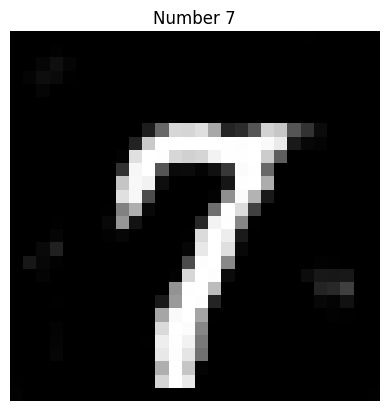

In [ ]:
# Example
number=7

noise=torch.randn(1, z_dim, device=device)
number_ohe=nn.functional.one_hot(torch.tensor([number]).to(device), n_classes)
noise_labels=concat_vectors(noise, number_ohe)[:, :, None, None]
generated_example=generator(noise_labels).detach().cpu().squeeze().numpy()
plt.imshow(generated_example, cmap="gray")
plt.title(f"Number {number}")
plt.axis("off");

In [ ]:
generator=generator.eval()

**Class vector interpolation**

In [ ]:
def show_images_interpolation(images, num_images=9, nrow=1, cmap="gray", title=""):
  images=(images+1)/2
  images=images.cpu()

  fig, axes = plt.subplots(1, num_images, figsize=(num_images, 2))
  fig.suptitle(title)
  for i, ax in enumerate(axes):
    ax.imshow(images[i].permute(1, 2, 0), cmap=cmap)
    ax.axis("off")

  plt.show()

In [ ]:
def interpolate_class(first_number, second_number, n_interpolation):
  interpolation_noise=torch.randn(1, z_dim, device=device).repeat(n_interpolation, 1)

  first_label=nn.functional.one_hot(torch.tensor([first_number]), n_classes)
  second_label=nn.functional.one_hot(torch.tensor([second_number]), n_classes)

  percent_second_label=torch.linspace(0, 1, n_interpolation)[:, None]
  interpolation_labels=first_label*(1-percent_second_label) + second_label*percent_second_label

  noise_and_labels=concat_vectors(interpolation_noise, interpolation_labels.to(device))
  fake_images=generator(noise_and_labels[:, :, None, None]).detach()
  show_images_interpolation(fake_images, n_interpolation, title=f"Class Intepolation; Numbers: {first_number}--->{second_number}")

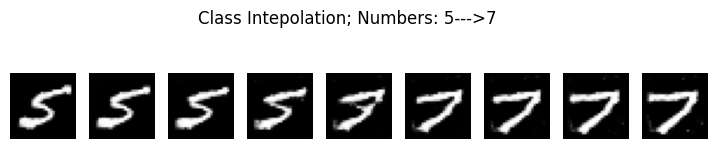

In [ ]:
interpolate_class(first_number=5, second_number=7, n_interpolation=9)

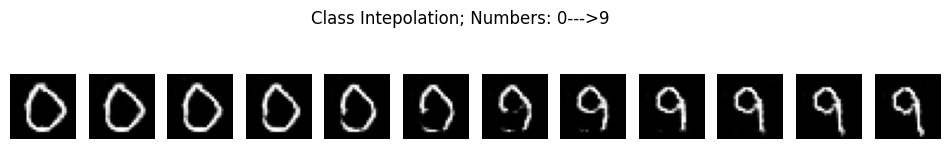

In [ ]:
interpolate_class(first_number=0, second_number=9, n_interpolation=12)

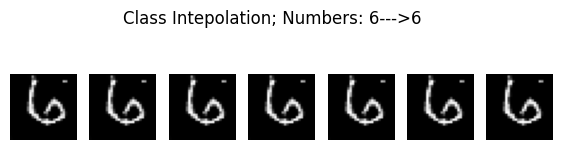

In [ ]:
interpolate_class(first_number=6, second_number=6, n_interpolation=7)

**Noise vector interpolation**

In [ ]:
def interpolate_noise(number, n_interpolation):
  first_noise=torch.randn(1, z_dim, device=device)
  second_noise=torch.randn(1, z_dim, device=device)

  interpolation_label=nn.functional.one_hot(torch.tensor([number]), n_classes).repeat(n_interpolation, 1)
  percent_first_noise=torch.linspace(0, 1, n_interpolation)[:, None].to(device)
  interpolation_noise=first_noise*percent_first_noise + second_noise*(1 - percent_first_noise)

  noise_and_labels=concat_vectors(interpolation_noise, interpolation_label.to(device))
  fake_images=generator(noise_and_labels[:, :, None, None]).detach()
  show_images_interpolation(fake_images, n_interpolation, title=f"Noise Intepolation; Number: {number}")

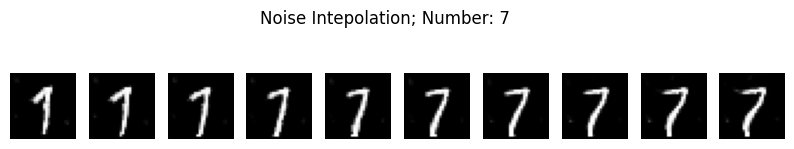

In [ ]:
interpolate_noise(number=7, n_interpolation=10)

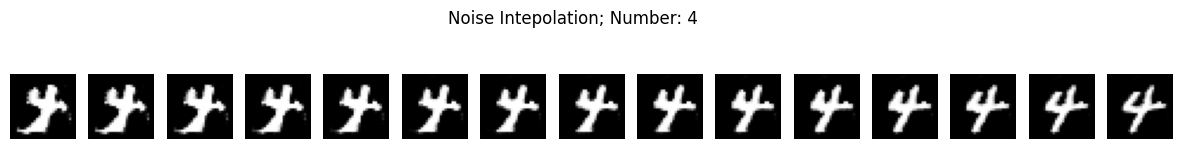

In [ ]:
interpolate_noise(number=4, n_interpolation=15)